# Feature Selection Techniques with Examples

In machine learning, Feature selection is the process of choosing variables that are useful in predicting the response (Y). It is considered a good practice to identify which features are important when building predictive models.

## Removing features with low variance

VarianceThreshold is a simple baseline approach to feature selection. It removes all features whose variance doesn’t meet some threshold. By default, it removes all zero-variance features, i.e. features that have the same value in all samples.

As an example, suppose that we have a dataset with boolean features, and we want to remove all features that are either one or zero (on or off) in more than 80% of the samples. Boolean features are Bernoulli random variables, and the variance of such variables is given by

> **Var[X] = p * (1-p)**

In [4]:
from sklearn.feature_selection import VarianceThreshold
X = [[0, 0, 1], [0, 1, 0], [1, 0, 0], [0, 1, 1], [0, 1, 0], [0, 1, 1]]
sel = VarianceThreshold(threshold=(0.8 * (1 - 0.8)))
sel.fit_transform(X)

array([[0, 1],
       [1, 0],
       [0, 0],
       [1, 1],
       [1, 0],
       [1, 1]])

As expected, VarianceThreshold has removed the first column, which has a probability (5/6) = 0.8  of containing a zero.

# Univariate feature selection

Statistical tests can be used to select those features that have the strongest relationship with the output variable.

The scikit-learn library provides the SelectKBest class that can be used with a suite of different statistical tests to select a specific number of features.

- SelectKBest removes all but the  highest scoring features
- SelectPercentile removes all but a user-specified highest scoring percentage of features

Many different statistical test scan be used with this selection method. For example the ANOVA F-value method is appropriate for numerical inputs and categorical data.

For instance, we can perform a test to the samples to retrieve only the two best features as follows:

In [35]:
# Feature Selection with Univariate Statistical Tests
from pandas import read_csv
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# load data
filename = 'pima-indians-diabetes.data.csv'
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = read_csv(filename, names=names)
array = dataframe.values

X = array[:,0:8]
Y = array[:,8]

# feature extraction
test = SelectKBest(score_func=f_classif, k=4)
fit = test.fit(X, Y)

# summarize scores
set_printoptions(precision=3)
print(fit.scores_)

features = fit.transform(X)

# You can see the scores for each attribute and the 4 attributes chosen (those with the highest scores).
# Specifically features with indexes 0 (preq), 1 (plas), 5 (mass), and 7 (age).

# summarize selected features
print(features[0:5,:])

[ 39.67  213.162   3.257   4.304  13.281  71.772  23.871  46.141]
[[  6.  148.   33.6  50. ]
 [  1.   85.   26.6  31. ]
 [  8.  183.   23.3  32. ]
 [  1.   89.   28.1  21. ]
 [  0.  137.   43.1  33. ]]


## Feature Importance
Bagged decision trees like Random Forest and Extra Trees can be used to estimate the importance of features.

In the example below we construct a ExtraTreesClassifier classifier for the Pima Indians onset of diabetes dataset. You can learn more about the ExtraTreesClassifier class in the scikit-learn API.

In [39]:
# Feature Importance with Extra Trees Classifier
from pandas import read_csv
from sklearn.ensemble import ExtraTreesClassifier

# load data
filename = 'pima-indians-diabetes.data.csv'
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = read_csv(filename, names=names)
array = dataframe.values
X = array[:,0:8]
Y = array[:,8]

# feature extraction
model = ExtraTreesClassifier(n_estimators=10)
model.fit(X, Y)
print(model.feature_importances_)

[0.117 0.23  0.104 0.085 0.075 0.132 0.113 0.145]


# Recursive feature elimination
Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through any specific attribute (such as coef_, feature_importances_) or callable. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

RFECV performs RFE in a cross-validation loop to find the optimal number of features.

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

>2 0.719 (0.049)
>3 0.820 (0.035)
>4 0.879 (0.031)
>5 0.884 (0.033)
>6 0.883 (0.028)
>7 0.889 (0.028)
>8 0.890 (0.028)
>9 0.886 (0.025)


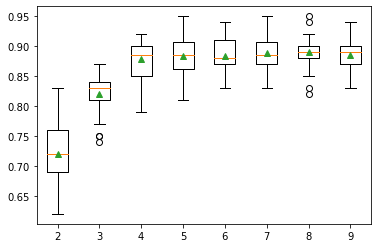

In [31]:
# explore the number of selected features for RFE
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from matplotlib import pyplot

# get the dataset
def get_dataset():
    X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
    return X, y

# get a list of models to evaluate
def get_models():
    models = dict()
    for i in range(2, 10):
        rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=i)
        model = DecisionTreeClassifier()
        models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
    return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

#### Which Features Were Selected

In [32]:
# report which features were selected by RFE
from sklearn.datasets import make_classification
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
# define dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# define RFE
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5)
# fit RFE
rfe.fit(X, y)
# summarize all features
for i in range(X.shape[1]):
    print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

Column: 0, Selected False, Rank: 4.000
Column: 1, Selected False, Rank: 5.000
Column: 2, Selected True, Rank: 1.000
Column: 3, Selected True, Rank: 1.000
Column: 4, Selected True, Rank: 1.000
Column: 5, Selected False, Rank: 6.000
Column: 6, Selected True, Rank: 1.000
Column: 7, Selected False, Rank: 2.000
Column: 8, Selected True, Rank: 1.000
Column: 9, Selected False, Rank: 3.000


# Sequential feature selection

In [19]:
from sklearn.datasets import load_diabetes

diabetes = load_diabetes()
X, y = diabetes.data, diabetes.target

In [22]:
print(diabetes.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

### Feature importance from coefficients
The features with the highest absolute coef_ value are considered the most important. We can observe the coefficients directly without needing to scale them (or scale the data) because from the description above, we know that the features were already standardized.

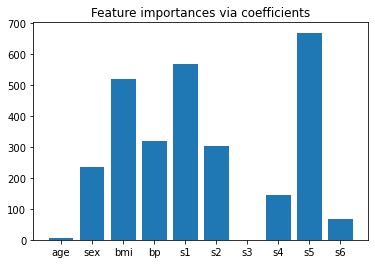

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LassoCV

lasso = LassoCV().fit(X, y)
importance = np.abs(lasso.coef_)
feature_names = np.array(diabetes.feature_names)
plt.bar(height=importance, x=feature_names)
plt.title("Feature importances via coefficients")
plt.show()

## Selecting features based on importance
Now we want to select the two features which are the most important according to the coefficients.

**sklearn.feature_selection.SelectFromModel** accepts a threshold parameter and will select the features whose importance (defined by the coefficients) are above this threshold.

Since we want to select only 2 features, we will set this threshold slightly above the coefficient of third most important feature.

In [24]:
from sklearn.feature_selection import SelectFromModel

threshold = np.sort(importance)[-3] + 0.01

sfm = SelectFromModel(lasso, threshold=threshold).fit(X, y)

print("Features selected by SelectFromModel: " f"{feature_names[sfm.get_support()]}")
print(f"Done in {toc - tic:.3f}s")

Features selected by SelectFromModel: ['s1' 's5']
Done in 0.198s


## Selecting features with Sequential Feature Selection
Another way of selecting features is to use **sklearn.feature_selection.SequentialFeatureSelector (SFS)**.

SFS is a greedy procedure where, at each iteration, we choose the best new feature to add to our selected features based a cross-validation score. That is, we start with 0 features and choose the best single feature with the highest score. The procedure is repeated until we reach the desired number of selected features.

We can also go in the reverse direction (backward SFS), i.e. start with all the features and greedily choose features to remove one by one. We illustrate both approaches here.

In [26]:
from sklearn.feature_selection import SequentialFeatureSelector

# Forward Selection
sfs_forward = SequentialFeatureSelector(
    lasso, 
    n_features_to_select=2,
    direction='forward'
).fit(X, y)

print("Features selected by forward sequential selection: " f"{feature_names[sfs_forward.get_support()]}")


Features selected by forward sequential selection: ['bmi' 's5']


In [27]:
# backward elemination
sfs_backward = SequentialFeatureSelector(
    lasso, 
    n_features_to_select=2,
    direction='backward'
).fit(X, y)

print("Features selected by backward sequential selection: " f"{feature_names[sfs_backward.get_support()]}")

Features selected by backward sequential selection: ['bmi' 's5']


Interestingly, forward and backward selection have selected the same set of features. In general, this isn't the case and the two methods would lead to different results.

# Principal Component Analysis

Principal Component Analysis (or PCA) uses linear algebra to transform the dataset into a compressed form.

Generally this is called a data reduction technique. A property of PCA is that you can choose the number of dimensions or principal component in the transformed result.

In the example below, we use PCA and select 3 principal components.

In [37]:
# Feature Extraction with PCA
import numpy
from pandas import read_csv
from sklearn.decomposition import PCA

# load data
filename = 'pima-indians-diabetes.data.csv'
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = read_csv(filename, names=names)
array = dataframe.values
X = array[:,0:8]
Y = array[:,8]

# feature extraction
pca = PCA(n_components=3)
fit = pca.fit(X)

# summarize components
print("Explained Variance: %s" % fit.explained_variance_ratio_)
print(fit.components_)

Explained Variance: [0.889 0.062 0.026]
[[-2.022e-03  9.781e-02  1.609e-02  6.076e-02  9.931e-01  1.401e-02
   5.372e-04 -3.565e-03]
 [-2.265e-02 -9.722e-01 -1.419e-01  5.786e-02  9.463e-02 -4.697e-02
  -8.168e-04 -1.402e-01]
 [-2.246e-02  1.434e-01 -9.225e-01 -3.070e-01  2.098e-02 -1.324e-01
  -6.400e-04 -1.255e-01]]


## Feature Selection Checklist

1. Do you have domain knowledge? If yes, construct a better set of ad hoc”” features
2. Are your features commensurate? If no, consider normalizing them.
3. Do you suspect interdependence of features? If yes, expand your feature set by constructing conjunctive features or products of features, as much as your computer resources allow you.
4. Do you need to prune the input variables (e.g. for cost, speed or data understanding reasons)? If no, construct disjunctive features or weighted sums of feature
5. Do you need to assess features individually (e.g. to understand their influence on the system or because their number is so large that you need to do a first filtering)? If yes, use a variable ranking method; else, do it anyway to get baseline results.
6. Do you need a predictor? If no, stop
7. Do you suspect your data is “dirty” (has a few meaningless input patterns and/or noisy outputs or wrong class labels)? If yes, detect the outlier examples using the top ranking variables obtained in step 5 as representation; check and/or discard them.
8. Do you know what to try first? If no, use a linear predictor. Use a forward selection method with the “probe” method as a stopping criterion or use the 0-norm embedded method for comparison, following the ranking of step 5, construct a sequence of predictors of same nature using increasing subsets of features. Can you match or improve performance with a smaller subset? If yes, try a non-linear predictor with that subset.
9. Do you have new ideas, time, computational resources, and enough examples? If yes, compare several feature selection methods, including your new idea, correlation coefficients, backward selection and embedded methods. Use linear and non-linear predictors. Select the best approach with model selection
10. Do you want a stable solution (to improve performance and/or understanding)? If yes, subsample your data and redo your analysis for several “bootstrap”.